In [2]:
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.interpolate import interp1d
np.set_printoptions(suppress=True)

# Estimating Probability of A Common Cause

### Model Parameters

In [3]:
pCommon = 0.28 #the probability of there being a single cause of sensory stimuli
sigV = 2.14 #visual noise
varV = sigV**2
sigA = 9.2#auditory noise
varA = sigA**2
sigP = 12.3#bias towards perceiving stimuli centrally
varP = sigP**2

N = 10000 #number of simulations

Sv = 0 #real stim location
Sa = 10 #real stim location


Xv = sigV * np.random.randn(N,1) + Sv #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
Xa = sigA * np.random.randn(N,1) + Sa #draw Xa from N(Sa, sigA) //Xa is perceived location of auditory stim

##### Calculate posterior probability of common cause

In [4]:
def calculate_likelihood_common_cause(Xv, Xa):
    #calculate the likelihood P(Xv, Xa|C =1)
    #i.e. the probability of perceiving visual and auditory stimulus given a common cause
    firstDenom = 2*np.pi*np.sqrt(varV*varA + varV*varP +varA*varP)
    firstTerm = 1/firstDenom 
    secondNum = (Xv - Xa)**2 * varP + (Xv -0)**2 * varA + (Xa - 0)**2* varV 
    secondDenom = (varV * varA) + (varV * varP) + (varA * varP)
    secondTerm = np.exp((-0.5*(secondNum/secondDenom)))
    likelihood_com = firstTerm*secondTerm
    return likelihood_com

In [5]:
def calculate_likelihood_ind_cause(Xv,Xa):
    #calculate the likelihood P(Xv, Xa|C =2)
    #i.e. the probability of perceiving visual and auditory stimulus given two independent cause
    firstTerm = 2*np.pi*np.sqrt((varV + varP)*(varA+varP))
    secondTerm1 = (Xv - 0)**2/(varV + varP)
    secondTerm2 = (Xa - 0)**2 / (varA + varP)
    secondTermFull = np.exp((-0.5*(secondTerm1+secondTerm2)) )
    likelihood_ind = secondTermFull/firstTerm
    return likelihood_ind

In [6]:
def calculate_posterior(Xv, Xa,verbose = False):
    #calculate p(C = 1|Xv,Xa) posterior
    #i.e. probability of stimuli coming from a common source
    likelihood_common = calculate_likelihood_common_cause(Xv,Xa)
    likelihood_ind = calculate_likelihood_ind_cause(Xv,Xa)
    post_common = likelihood_common * pCommon 
    post_indep = likelihood_ind * (1-pCommon)
    posterior = post_common/(post_common +post_indep)
    if verbose == True:
         print('posterior: ', posterior)
    return posterior

In [7]:
posteriors = calculate_posterior(Xv,Xa,True)

posterior:  [[0.02835422]
 [0.10358821]
 [0.25993183]
 ...
 [0.26742952]
 [0.10830539]
 [0.3969321 ]]


When P(C=1| Xv,Xa) > 0.5, the model reports a common cause.

# Optimally Estimating the Position

First need to calculate the best estimates of stimulus location that we would obtain if we were certain about there being one or two causes, respectively. These *conditionalized* solutions are obtained by linearly weighting the different cues proportional to their inverse variances.

We calculate the optimal conditionialised solution if there is one common cause of sensory signals and two causes.

In [8]:
def opt_position_conditionalised_C1(Xv,Xa):
    #find the optimum estimate of stimulus position if we were
    #certain the stimuli were caused by a common cause
    cues = Xv/varV + Xa/varA + ml.repmat(pCommon,N,1)/varP
    inverseVar = 1/varV + 1/varA + 1/varP
    sHatC1 = cues/inverseVar
    return sHatC1

def opt_position_conditionalised_C2(Xv, Xa):
    #find the optimum estimate of stimulus position if we were
    #certain the stimuli were caused by independent causes
    visualCue = Xv/varV +ml.repmat(pCommon,N,1)/varP
    visualInvVar = 1/varV + 1/ varP
    sHatVC2 = visualCue/visualInvVar
    audCue = Xa/varA + ml.repmat(pCommon,N,1)/varP
    audInvVar = 1/varA + 1/ varP
    sHatAC2 = audCue/audInvVar
    return sHatVC2, sHatAC2

Using these conditionalised solutions we can caluclate the optimal estimate for locations of both visual and auditory estimates.

In [9]:
def optimal_visual_location(Xv,Xa):
    #returns an array of length = NumSimulations with values of 
    #optimal estimate of visual stimulus location for each
    #simulation trial
    posterior_1C = calculate_posterior(Xv,Xa)
    sHatVC1 = opt_position_conditionalised_C1(Xv,Xa)
    sHatVC2 = opt_position_conditionalised_C2(Xv,Xa)[0]
    sHatV = posterior_1C*sHatVC1 + (1-posterior_1C)*sHatVC2 #model averaging
    return sHatV

def optimal_aud_location(Xv,Xa):
    #returns an array of length = NumSimulations with values of 
    #optimal estimate of auditory stimulus location for each
    #simulation trial
    posterior_1C = calculate_posterior(Xv,Xa)
    sHatAC1 = opt_position_conditionalised_C1(Xv,Xa)
    sHatAC2 = opt_position_conditionalised_C2(Xv,Xa)[1]
    sHatA = posterior_1C*sHatAC1 + (1-posterior_1C)*sHatAC2 #model averaging
    return sHatA

In [10]:
sV_hat = optimal_visual_location(Xv,Xa)
sA_hat = optimal_aud_location(Xv,Xa)

In [11]:
def plot_pred_dist(sV_hat,sA_hat,nBins,extra= False):

    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram


    pV, x = np.histogram(sV_hat, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predV = np.divide(pV,sum(pV)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    est_V_y = interp1d(x, freq_predV) #create interpolation function for the freq_predV curve
    plt.plot(x, freq_predV,'b') #plot distribution of visual estimates

    pA, x = np.histogram(sA_hat, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predA = np.divide(pA,sum(pA)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    est_A_y = interp1d(x,freq_predA)#create interpolation function for the freq_predA curve
    plt.plot(x, freq_predA,'r') #plot distribution of auditory estimates

    if extra == True:
        #calculate mean estimates 
        mean_sV_hat = np.mean(sV_hat)
        mean_sA_hat = np.mean(sA_hat)
        print('The prediction for visual location is ',mean_sV_hat)
        print('The prediction for auditory location is ',mean_sA_hat)

        #plot real stimulus location
        plt.axvline(x=Sv,color='b',linestyle='--')
        plt.axvline(x=Sa,color='r',linestyle='--')
        plt.legend(['visual','auditory'])
        ax = plt.gca()

        #plot parameters
        plt.ylim(0)
        plt.xlabel('Location (arbitrary units)')
        plt.ylabel('Probability')

        #plot mean estimates
        plt.plot(mean_sV_hat, est_V_y(mean_sV_hat), marker='.', markersize=15, color="blue")
        plt.text(mean_sV_hat, est_V_y(mean_sV_hat), str(np.round(mean_sV_hat,2)), horizontalalignment='right',verticalalignment='bottom',fontsize=14)
        plt.plot(mean_sA_hat, est_A_y(mean_sA_hat), marker='.', markersize=15, color="red")
        plt.text(mean_sA_hat, est_A_y(mean_sA_hat), str(np.round(mean_sA_hat,2)), horizontalalignment='right',verticalalignment='bottom',fontsize=14)
        plt.show()
        

The prediction for visual location is  0.08132465238710575
The prediction for auditory location is  5.4671126799469985


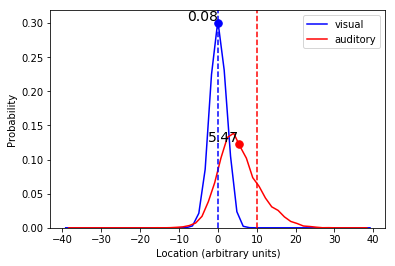

In [12]:
plot_pred_dist(sV_hat,sA_hat,50,True)

# Replicate Histograms that can be compared to Human Data

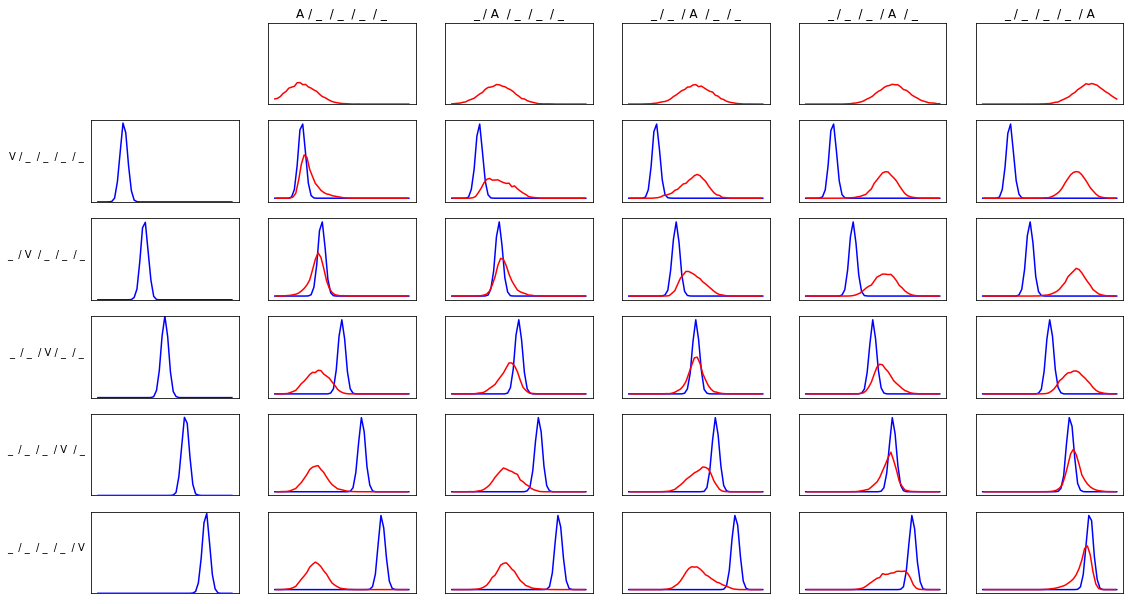

In [14]:
visLocations = [-24,-12,0,12,24]
audLocations = [-24,-12,0,12,24]
nBins = 50
plotCount = 8
for Sv in visLocations:
    for Sa in audLocations:
        Xv = sigV * np.random.randn(N,1) + Sv #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
        Xa = sigA * np.random.randn(N,1) + Sa #draw Xa from N(Sa, sigA) //Xa is perceived location of auditory stim
        sV_hat = optimal_visual_location(Xv,Xa)
        sA_hat = optimal_aud_location(Xv,Xa)
        
        f = plt.subplot(6,6,plotCount)
        frame1 = plt.gcf()
        ax = plt.gca()
        frame1.set_size_inches(18.5, 10.5)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plot_pred_dist(sV_hat,sA_hat,50)
        if plotCount%6==0:
            plotCount+=2
        else:
            plotCount += 1

plotCount = 7        
for sV in visLocations:
    
    Xv = sigV * np.random.randn(N,1) + sV #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
  

    pV, x = np.histogram(Xv, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predV = np.divide(pV,sum(pV)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 7:
        f.set_ylabel('V / _  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 13:
        f.set_ylabel('_  / V  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 19:
        f.set_ylabel('_  / _  / V / _  / _',rotation=0,labelpad = 45)
    if plotCount == 25: 
        f.set_ylabel('_  / _  / _  / V  / _',rotation=0,labelpad = 45)
    if plotCount == 31: 
        f.set_ylabel('_  / _  / _  / _  / V',rotation=0,labelpad = 45)
    frame1 = plt.gcf()
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predV,'b') #plot distribution of visual estimates
    plotCount+=6

plotCount = 2  
for sA in audLocations:
    
    Xa = sigA * np.random.randn(N,1) + sA #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
    

    pA, x = np.histogram(Xa, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predA = np.divide(pA,sum(pA)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 2:
        f.set_title('A / _  / _  / _  / _')
    if plotCount == 3:
        f.set_title('_ / A  / _  / _  / _')
    if plotCount == 4:
        f.set_title('_ / _  / A  / _  / _')
    if plotCount == 5:
        f.set_title('_ / _  / _  / A  / _')
    if plotCount == 6:
        f.set_title('_ / _  / _  / _  / A')
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predA,'r') #plot distribution of auditory estimates
    plotCount+=1
                
        

# Compare with hypothesised distributions for AN patients with highly weighted visual input.

It's been hypothesised that Anorexic patients weight their visual input much higher than healthy controls (Kaplan et al., 2014; Eshkevari et al. 2011). This can be modeled by increasing the precision of the visual input.

In [15]:
sigV = 0.5 #visual noise
varV = sigV**2
sigA = 9.2#auditory noise
varA = sigA**2
sigP = 12.3#bias towards perceiving stimuli centrally
varP = sigP**2

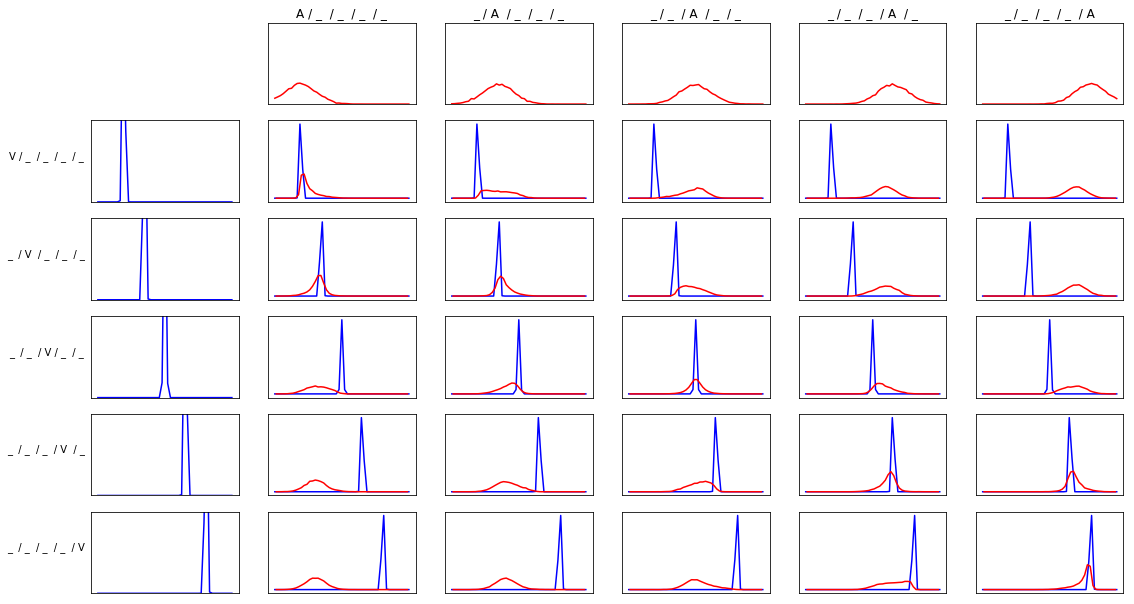

In [16]:
visLocations = [-24,-12,0,12,24]
audLocations = [-24,-12,0,12,24]
nBins = 50
plotCount = 8
for Sv in visLocations:
    for Sa in audLocations:
        Xv = sigV * np.random.randn(N,1) + Sv #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
        Xa = sigA * np.random.randn(N,1) + Sa #draw Xa from N(Sa, sigA) //Xa is perceived location of auditory stim
        sV_hat = optimal_visual_location(Xv,Xa)
        sA_hat = optimal_aud_location(Xv,Xa)
        
        f = plt.subplot(6,6,plotCount)
        frame1 = plt.gcf()
        ax = plt.gca()
        frame1.set_size_inches(18.5, 10.5)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plot_pred_dist(sV_hat,sA_hat,50)
        if plotCount%6==0:
            plotCount+=2
        else:
            plotCount += 1

plotCount = 7        
for sV in visLocations:
    
    Xv = sigV * np.random.randn(N,1) + sV #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
  

    pV, x = np.histogram(Xv, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predV = np.divide(pV,sum(pV)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 7:
        f.set_ylabel('V / _  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 13:
        f.set_ylabel('_  / V  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 19:
        f.set_ylabel('_  / _  / V / _  / _',rotation=0,labelpad = 45)
    if plotCount == 25: 
        f.set_ylabel('_  / _  / _  / V  / _',rotation=0,labelpad = 45)
    if plotCount == 31: 
        f.set_ylabel('_  / _  / _  / _  / V',rotation=0,labelpad = 45)
    frame1 = plt.gcf()
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predV,'b') #plot distribution of visual estimates
    plotCount+=6

plotCount = 2  
for sA in audLocations:
    
    Xa = sigA * np.random.randn(N,1) + sA #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
    

    pA, x = np.histogram(Xa, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predA = np.divide(pA,sum(pA)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 2:
        f.set_title('A / _  / _  / _  / _')
    if plotCount == 3:
        f.set_title('_ / A  / _  / _  / _')
    if plotCount == 4:
        f.set_title('_ / _  / A  / _  / _')
    if plotCount == 5:
        f.set_title('_ / _  / _  / A  / _')
    if plotCount == 6:
        f.set_title('_ / _  / _  / _  / A')
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predA,'r') #plot distribution of auditory estimates
    plotCount+=1
                
        

# Compare with hypothesised distributions of AN patients with less precise bottom-up signals.

It has, however, also been hypothesised that AN patients may suffer from poor bottom-up sensory signal precision (Gadsby and Hohwy, 2019).

In [17]:
sigV = 3.5 #visual noise
varV = sigV**2
sigA = 12#auditory noise
varA = sigA**2
sigP = 12.3#bias towards perceiving stimuli centrally
varP = sigP**2

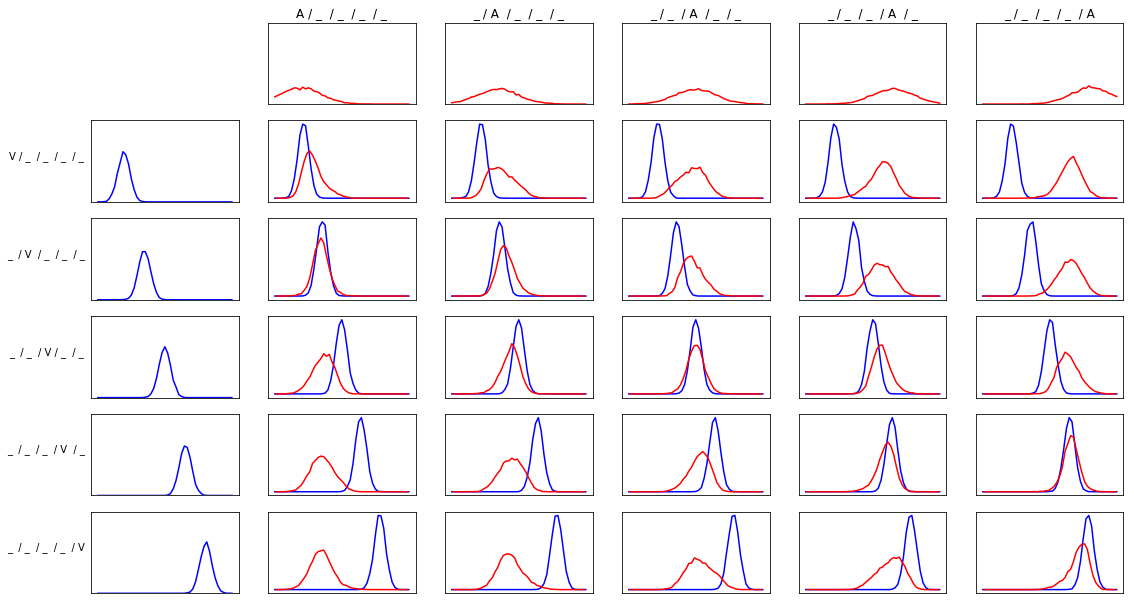

In [18]:
visLocations = [-24,-12,0,12,24]
audLocations = [-24,-12,0,12,24]
nBins = 50
plotCount = 8
for Sv in visLocations:
    for Sa in audLocations:
        Xv = sigV * np.random.randn(N,1) + Sv #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
        Xa = sigA * np.random.randn(N,1) + Sa #draw Xa from N(Sa, sigA) //Xa is perceived location of auditory stim
        sV_hat = optimal_visual_location(Xv,Xa)
        sA_hat = optimal_aud_location(Xv,Xa)
        
        f = plt.subplot(6,6,plotCount)
        frame1 = plt.gcf()
        ax = plt.gca()
        frame1.set_size_inches(18.5, 10.5)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        plot_pred_dist(sV_hat,sA_hat,50)
        if plotCount%6==0:
            plotCount+=2
        else:
            plotCount += 1

plotCount = 7        
for sV in visLocations:
    
    Xv = sigV * np.random.randn(N,1) + sV #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
  

    pV, x = np.histogram(Xv, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predV = np.divide(pV,sum(pV)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 7:
        f.set_ylabel('V / _  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 13:
        f.set_ylabel('_  / V  / _  / _  / _',rotation=0,labelpad = 45)
    if plotCount == 19:
        f.set_ylabel('_  / _  / V / _  / _',rotation=0,labelpad = 45)
    if plotCount == 25: 
        f.set_ylabel('_  / _  / _  / V  / _',rotation=0,labelpad = 45)
    if plotCount == 31: 
        f.set_ylabel('_  / _  / _  / _  / V',rotation=0,labelpad = 45)
    frame1 = plt.gcf()
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predV,'b') #plot distribution of visual estimates
    plotCount+=6

plotCount = 2  
for sA in audLocations:
    
    Xa = sigA * np.random.randn(N,1) + sA #draw Xv from N(Sv, sigV) //Xv is perceived location of visual stim
    x = np.linspace(-40,40,nBins) #x axis for plot and creates bin edges for histogram
    

    pA, x = np.histogram(Xa, bins=x) # bin it nBins bins with bin edges defined by x
    freq_predA = np.divide(pA,sum(pA)) #return frequency of each bin
    x = x[:-1] + ((x[1:] - x[:-1])/2) #calculate bin centers and use these on x axis
    
    f = plt.subplot(6,6,plotCount)
    if plotCount == 2:
        f.set_title('A / _  / _  / _  / _')
    if plotCount == 3:
        f.set_title('_ / A  / _  / _  / _')
    if plotCount == 4:
        f.set_title('_ / _  / A  / _  / _')
    if plotCount == 5:
        f.set_title('_ / _  / _  / A  / _')
    if plotCount == 6:
        f.set_title('_ / _  / _  / _  / A')
    frame1 = plt.gcf()
    ax = plt.gca()
    frame1.set_size_inches(18.5, 10.5)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_ylim([0,0.3])
    plt.plot(x, freq_predA,'r') #plot distribution of auditory estimates
    plotCount+=1
                
        